# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [1]:
import functools
import numpy as np

def robustness(direction, threshold, data):
    if data.size == 1:
        if direction == SMALLER:
            return float(data <= threshold)
        else:
            return float(data >= threshold)
    else:
        if direction == SMALLER:
            return np.sum(data<=threshold)/data.shape[0]
        else:
            return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)




**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

Set up model

In [2]:
import lakemodel_function as lmf
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging, Constant, Constraint)
from ema_workbench.em_framework.evaluators import MC
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
import pandas as pd

lake_model = Model('Lakemodel', function=lmf.lake_problem)

In [3]:
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

lake_model.time_horizon = 100 

lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here



Generate 4 random release policies and evaluate them over 500 scenarios

In [25]:
n_policies = 4

scenarios=[1,2,3,4,5,6,100, 200, 500]

all_results = pd.DataFrame()
with MultiprocessingEvaluator(lake_model) as evaluator:
    for n_scenarios in scenarios:
        experiments, results = evaluator.perform_experiments(policies=n_policies, scenarios=n_scenarios, uncertainty_sampling=MC)
        experiments["max_p"] = results["max_P"]
        experiments["utility"] = results["utility"]
        experiments["inertia"] = results["inertia"]
        experiments["reliability"] = results["reliability"]
        experiments["runs"] = n_scenarios
        all_results = pd.concat([all_results, experiments], axis=0)

In [26]:
grouped = all_results.groupby(by=["runs"])

In [27]:
free_realestate = pd.DataFrame(columns=["max_p", "utility", "inertia", "reliability"])
i = 0
for group in grouped:
    free_realestate.loc[group[0]] = [maxp(group[1]["max_p"])] + [utility(group[1]["utility"])] + [inertia(group[1]["inertia"])] + [reliability(group[1]["reliability"])]
    i+= 1

<AxesSubplot:>

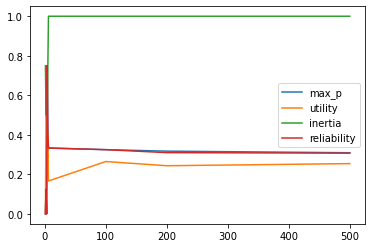

In [29]:
free_realestate.plot()

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

In [5]:
from ema_workbench import SequentialEvaluator

In [6]:
nfe = 10
epsilons = [0.05] * 4
n_scenarios = 5

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

constraints = [Constraint("max pollution", outcome_names="max_P", function=maxp),
              Constraint("inertia", outcome_names="inertia", function=inertia),
              Constraint("reliability", outcome_names="reliability", function=reliability),
              Constraint("utility", outcome_names="utility", function=utility)]


robustnes_functions = [ScalarOutcome('max_P', kind=MINIMIZE,
                             variable_name='max_P', function=maxp),
                       ScalarOutcome('reliability', kind=MAXIMIZE,
                             variable_name='reliability', function=reliability),
                       ScalarOutcome('inertia', kind=MAXIMIZE,
                             variable_name='inertia', function=inertia),
                       ScalarOutcome('utility', kind=MAXIMIZE,
                             variable_name='utility', function=utility)]


with SequentialEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustnes_functions, n_scenarios, nfe=nfe, epsilons=epsilons, convergence=convergence_metrics, constraints=constraints)

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?